In [1]:
!pip install geojson

In [2]:
# Imports here
import os

from google.cloud import storage

from IPython.display import clear_output

# Create the service client.
from googleapiclient.discovery import build
from apiclient.http import MediaIoBaseDownload
from skimage.util import view_as_blocks, pad
import os.path
import math
import requests
import json
import subprocess
from osgeo import ogr, osr, gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geojson as gj

from PIL import Image

In [3]:
# Shell commands necessary to run code
%env ORDER_NAME=chimbote
%env ITEM_TYPE=PSScene4Band
%env BAND_ID=_3B_AnalyticMS
%env ITEM_ID_PATH=item_ids.txt
%env DL_IMAGE_PATH=/content/
%env PATH_PREFIX=chimbote/
%env BUCKET_NAME=planet_imagery
# REMEMBER to upload google_creds.json on startup
%env GOOGLE_APPLICATION_CREDENTIALS=google_creds.json

env: ORDER_NAME=chimbote
env: ITEM_TYPE=PSScene4Band
env: BAND_ID=_3B_AnalyticMS
env: ITEM_ID_PATH=item_ids.txt
env: DL_IMAGE_PATH=/content/
env: PATH_PREFIX=chimbote/
env: BUCKET_NAME=planet_imagery
env: GOOGLE_APPLICATION_CREDENTIALS=google_creds.json


In [4]:
# GOOGLE CREDS is different for notebook – change for .py files
GOOGLE_APPLICATION_CREDENTIALS = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
BUCKET_NAME = os.getenv('BUCKET_NAME')
PATH_PREFIX = os.getenv('PATH_PREFIX')
ITEM_TYPE = os.getenv('ITEM_TYPE')
ITEM_ID_PATH = os.getenv('ITEM_ID_PATH')
DL_IMAGE_PATH = os.getenv('DL_IMAGE_PATH')
BAND_ID = os.getenv('BAND_ID')
ORDER_NAME = os.getenv('ORDER_NAME')

In [5]:
def download_img(dl_path, id_num):
    gcs_service = build('storage', 'v1')
    if not os.path.exists(os.path.dirname(dl_path)):
        try:
            os.makedirs(os.path.dirname(dl_path))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    with open(dl_path, 'wb') as f:
      # Download the file from the Google Cloud Storage bucket.
      request = gcs_service.objects().get_media(bucket=BUCKET_NAME,
                                                object=dl_path)
      media = MediaIoBaseDownload(f, request)
      print('Downloading item ', id_num + 1, '...')
      print('Download Progress: ')
      done = False
      while not done:
          prog, done = media.next_chunk()
          print(prog.progress())

    print('Image ', id_num + 1, ' downloaded.')
    return dl_path


def get_img_paths(dirpath, bucket_name, dl=True, max_num_imgs=None, skip_first=0):
    client = storage.Client()
    id = 0
    for blob in client.list_blobs(bucket_name, prefix=dirpath):
      if max_num_imgs is not None:
        if id > max_num_imgs - 1:
          break
      filepath = blob.name
      if filepath[-14:] == 'AnalyticMS.tif':
        if id < skip_first:
          id += 1
          continue
        if dl == True:
          if not os.path.isfile(filepath):
              download_img(filepath, id)
        id += 1
        yield filepath, id


def load_img(img_path):
    '''Returns both the relevant geographic data, and other metadata such as
    cloudcover etc. and the img itself as a numpy array.
    '''
    ds = gdal.Translate('',
                    img_path,
                    options='-ot Byte -scale minval maxval -of MEM')
    b1, b2, b3, b4 = (ds.GetRasterBand(1).ReadAsArray(), 
                      ds.GetRasterBand(2).ReadAsArray(), 
                      ds.GetRasterBand(3).ReadAsArray(), 
                      ds.GetRasterBand(4).ReadAsArray())
    img_array = np.array((b3,b2,b1))
    img_array = np.moveaxis(img_array, 0, 2)
#    if plot_image:
#        plot_img(img_array, figsize)
    return img_array


def split_img(img_array, patch_shape=None, xoffset=0, yoffset=0):
  if patch_shape is None:
    return img_array
  img_shape = img_array.shape
  width, height = img_shape[:2]
  patch_width, patch_height = patch_shape[:2]
  width_remainder = width % patch_width
  height_remainder = height % patch_height

  pad_w = patch_width - width_remainder
  pad_h = patch_height - height_remainder

  half_pad_w = pad_w / 2
  half_pad_w_1 = int(math.ceil(half_pad_w))
  half_pad_w_2 = int(math.floor(half_pad_w))

  half_pad_h = pad_h / 2
  half_pad_h_1 = int(math.ceil(half_pad_h))
  half_pad_h_2 = int(math.floor(half_pad_h))
    
  img_padded = np.pad(img_array, 
                    [[half_pad_w_1, half_pad_w_2], 
                     [half_pad_h_1, half_pad_h_2], 
                     [0, 0]],
                    'constant', constant_values=(0))
  patches = view_as_blocks(img_padded, patch_shape)

  n_horz_patches = patches.shape[1] # Number of patches along x-axis
  n_ver_patches = patches.shape[0] # Number of patches along y-axis

  for i in range(n_ver_patches):
    my = i * patch_height + yoffset - half_pad_w_1
    for j in range(n_horz_patches):
      mx = j * patch_width + xoffset - half_pad_h_1
      yield (i, j), patches[i, j, :, :, :, :], mx, my

In [6]:
def prep_imgs(dirpath, bucketname, patch_shape=None, aoi=None, id_start_idx=55, 
              id_end_idx=-18, max_num_imgs=25, skip_first=0, plot_image=False, 
              figsize=(20,20), print_clip=False):
    img_paths = get_img_paths(dirpath, bucketname, 
                              max_num_imgs=max_num_imgs + skip_first, 
                              skip_first=skip_first)
    for img_path, idx in img_paths:
        item_id = img_path[id_start_idx:id_end_idx]
#        try:
        img_array= load_img(img_path)
#        except:
#            print('There was a problem loading image %s. Skipping.' % idx)
#            continue
        imgs_split = split_img(img_array, patch_shape)
        for (i, j), split, mx, my in imgs_split:
            subsample_id = str(i) + '_' + str(j)
            yield split[0,:,:,:], item_id, subsample_id

In [10]:
def label_imgs(img, item_id, subsample_id, test_dir, num_labeled, num_positive) -> [[str, str], None]:
    if not os.path.exists(os.path.dirname(test_dir)):
        try:
            os.makedirs(os.path.dirname(test_dir))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    # Print tile to screen
    clear_output(wait=True)
    sample_id = item_id + subsample_id
    print('Number of samples labeled: %d' % num_labeled)
    if num_labeled > 0:
        percent_pos = num_positive / num_labeled
        print('Percent positive: %f \n' % percent_pos)
    print(sample_id + '\n')
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.imshow(img)
    plt.show()
    # prompt user for label ([y]es, [n]o, ENTER for no label (None))
    while True:
        label = input('Vessel in image above ([y]es/[n]o; ENTER for no label, and q to quit)? \n')
        if len(label) == 0:
            label = None
        elif label in ['y', 'Y', 'yes', 'Yes', 'YES']:
            label = 1
        elif label in ['n', 'N', 'no', 'No', 'NO']:
            label = 0
        elif label in ['q', 'Q', 'quit', 'Quit', 'QUIT']:
            return -1
        else:
            print('Invalid input. Try again. \n')
            continue
        break
    if label is not None:
        # Save img to test directory
        savepath = test_dir + sample_id + '.jpg'
        img = Image.fromarray(img)
        img.save(savepath)
        return {'sample_id':sample_id, 'label':label}
    else:
        return None


In [8]:
def make_df(rows=None):
    col_names = ['sample_id', 'label']
    df = pd.DataFrame(columns=col_names)
    #df.set_index('target_id')
    if rows is not None:
          df = df.append(rows)
    return df

Number of samples labeled: 520
Percent positive: 0.103846 

20190102_150558_10327_7



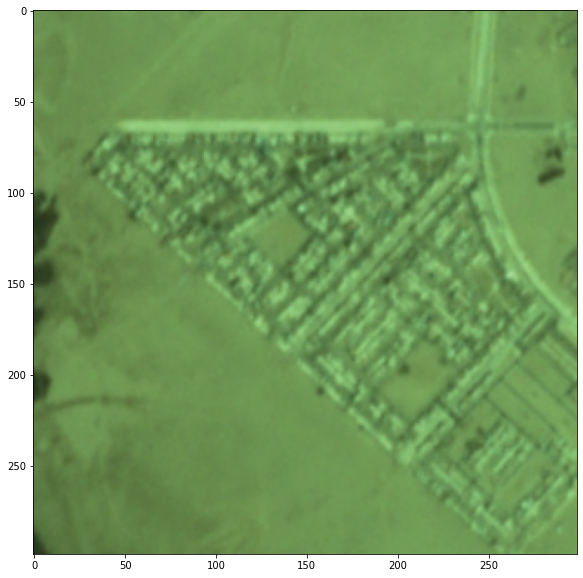

Vessel in image above ([y]es/[n]o; ENTER for no label, and q to quit)? 
q


In [12]:
if __name__ == '__main__':
    dirpath = r'chimbote/6b1c85ce-3b5b-490c-91e1-34262ada7d0c/PSScene4Band'
    test_dir = r'/content/test/'
    aoi = None
    imgs = prep_imgs(dirpath, BUCKET_NAME, (299, 299, 3), aoi=aoi, id_start_idx=59, id_end_idx=-18,
                    max_num_imgs=np.float('inf'), skip_first=0, plot_image=False, print_clip=False)
    labels = []
    num_labeled = 0
    num_positive = 0
    for img, item_id, subsample_id, in imgs:
        label = label_imgs(img, item_id, subsample_id, test_dir, num_labeled, 
                           num_positive)
        if label == -1:
            break
        if label is not None:
            num_labeled += 1
            num_positive += label['label']
            labels.append(label)

    df = make_df(labels)

In [13]:
df.head()

,sample_id,label
0,20190101_150711_0f510_0,0
1,20190101_150711_0f510_1,0
2,20190101_150711_0f510_2,0
3,20190101_150711_0f510_3,0
4,20190101_150711_0f510_4,0


In [14]:
from google.cloud import storage
import glob


def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    # bucket_name = "your-bucket-name"
    # source_file_name = "local/path/to/file"
    # destination_blob_name = "storage-object-name"

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print(
        "File {} uploaded to {}.".format(
            source_file_name, destination_blob_name
        )
    )


def upload_dir(bucket_name, source_dir_name, destination_blob_dir):
    assert os.path.isdir(source_dir_name)
    for local_file in glob.glob(source_dir_name + '/**'):
        if not os.path.isfile(local_file):
            continue
        destination_blob_name = destination_blob_dir + os.path.basename(local_file)
        upload_blob(bucket_name, local_file, destination_blob_name)

In [15]:
bucket_name = BUCKET_NAME
source_dir_name = '/content/test/'
destination_blob_dir = 'test/imgs/'
upload_dir(bucket_name, source_dir_name, destination_blob_dir)

File /content/test/20190101_150711_0f517_5.jpg uploaded to test/imgs/20190101_150711_0f517_5.jpg.
File /content/test/20190101_150712_0f5113_22.jpg uploaded to test/imgs/20190101_150712_0f5113_22.jpg.
File /content/test/20190101_150712_0f513_14.jpg uploaded to test/imgs/20190101_150712_0f513_14.jpg.
File /content/test/20190101_150712_0f518_15.jpg uploaded to test/imgs/20190101_150712_0f518_15.jpg.
File /content/test/20190101_152751_0f3d13_4.jpg uploaded to test/imgs/20190101_152751_0f3d13_4.jpg.
File /content/test/20190101_150711_0f512_25.jpg uploaded to test/imgs/20190101_150711_0f512_25.jpg.
File /content/test/20190101_150711_0f512_5.jpg uploaded to test/imgs/20190101_150711_0f512_5.jpg.
File /content/test/20190101_150713_0f513_21.jpg uploaded to test/imgs/20190101_150713_0f513_21.jpg.
File /content/test/20190101_150713_0f5115_1.jpg uploaded to test/imgs/20190101_150713_0f5115_1.jpg.
File /content/test/20190101_152752_0f3d4_25.jpg uploaded to test/imgs/20190101_152752_0f3d4_25.jpg.
Fi

In [16]:
df.to_csv('/content/labels.csv')
bucket_name = BUCKET_NAME
source_file_name = '/content/labels.csv'
destination_blob_name = 'test/labels.csv'
upload_blob(bucket_name, source_file_name, destination_blob_name)

File /content/labels.csv uploaded to test/labels.csv.
